In [1]:
import os
import numpy as np
import math
from PIL import Image, ImageDraw
#from dwave.system import LeapHybridSampler ### I just wanted to test something but I ain't paying for QC just for testing lol
from dimod import BinaryQuadraticModel, SimulatedAnnealingSampler, BINARY
import matplotlib.pyplot as plt
import scipy.spatial

In [2]:
color_to_space = {
    (244, 242, 229): 'corridor',
    (208, 216, 135): 'terrace',
    (234, 216, 214): 'kitchen',
    (253, 244, 171): 'bedroom',
    (205, 233, 252): 'bathroom'
} #this color palette is taken from the dataset I provided in this example

In [3]:
def process_image(image_path):
    image = Image.open(image_path)
    image = image.convert('RGB')
    image_array = np.array(image)
    binary_variables = {}
    centroids = {}
    for y in range(image_array.shape[0]):
        for x in range(image_array.shape[1]):
            pixel = tuple(image_array[y, x])
            if pixel in color_to_space:
                space = color_to_space[pixel]
                if space not in centroids:
                    centroids[space] = []
                centroids[space].append((x, y))
    for space, points in centroids.items():
        x_coords, y_coords = zip(*points)
        min_x = min(x_coords)
        max_x = max(x_coords)
        min_y = min(y_coords)
        max_y = max(y_coords)
        centroid_x = int((min_x + max_x) / 2)
        centroid_y = int((min_y + max_y) / 2)
        centroid = (centroid_x, centroid_y)
        binary_variables[centroid] = space  # Add the centroid location to the binary variables
    return binary_variables, image_array

def process_images(image_files):
    binary_variables_combined = {}
    image_array = None
    for image_file in image_files:
        binary_variables, image_array = process_image(image_file)
        binary_variables_combined.update(binary_variables)
    return binary_variables_combined, image_array

In [4]:
images_dir = 'simple/' #or 'dataset/' but it contains over 1000 images which could take hours for the solver
image_files = [os.path.join(images_dir, file) for file in os.listdir(images_dir) if file.endswith('.png')]

In [5]:
%%time
#I added (%%time) this to calculate the ETA for dataset preprocessing
binary_variables_combined, image_array = process_images(image_files)
#This is a heavy processing cell so relax and have some tea :D
#NOTE: the dataset contains 1000 images, you don't need that much at all, you can use 1 image if you want :D

CPU times: total: 594 ms
Wall time: 592 ms


Space: terrace, Binary Variables: 1
Space: bedroom, Binary Variables: 1
Space: corridor, Binary Variables: 1
Space: kitchen, Binary Variables: 1
Space: bathroom, Binary Variables: 1


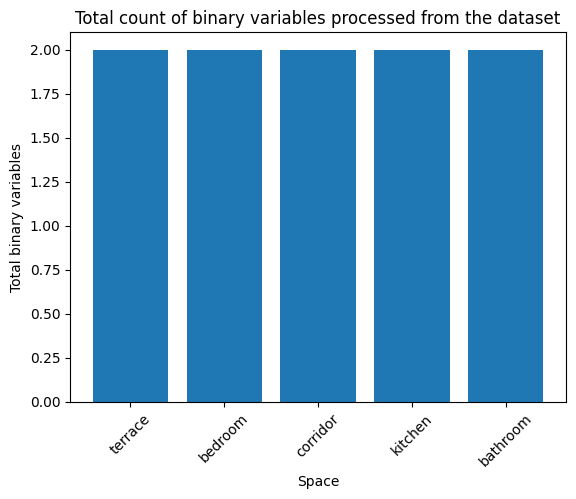

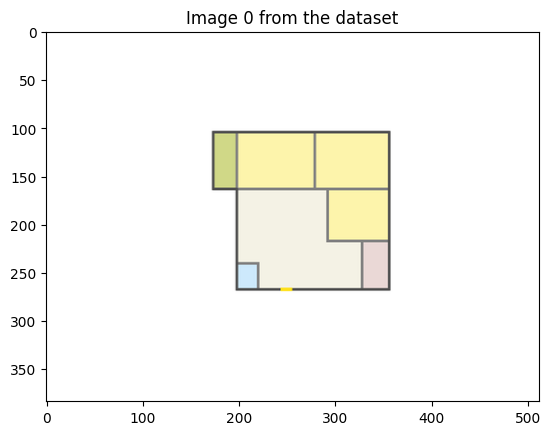

In [6]:
space_counts = {}
for space in binary_variables_combined.values():
    space_counts[space] = space_counts.get(space, 0) + 1

#Print the number of values for each space in the total dataset
for space, count in space_counts.items():
    print(f"Space: {space}, Binary Variables: {count}")

spaces = list(space_counts.keys())
counts = list(space_counts.values())

#Update the counts by adding the occurrences of each space type
for space, count in binary_variables_combined.items():
    counts[spaces.index(count)] += 1

#Visualization
plt.bar(spaces, counts)
plt.xlabel('Space')
plt.ylabel('Total binary variables')
plt.title('Total count of binary variables processed from the dataset')
plt.xticks(rotation=45)
plt.show()
__image = Image.open(image_files[0])
plt.imshow(np.array(__image))
plt.axis('on')
plt.title('Image 0 from the dataset')
plt.show()

In [7]:
# BQM implementation (I belive Dynex uses BINARY not SLIP)
bqm = BinaryQuadraticModel.empty(vartype=BINARY)
for coord, _ in binary_variables_combined.items():
    bqm.add_variable(coord, 0.0)
    bqm.set_linear(coord, 1.0) 

In [8]:
linear_coefficients = {coord: -1.0 for coord in binary_variables_combined.keys()}
quadratic_coefficients = {} #You could add the objective function coefficients (weights)

In [9]:
# Define the constraints
constraints = {
    'adjacency_relationships': [
        [('corridor', 'kitchen'), ('bedroom', 'bathroom')],
        [('terrace', 'bedroom'), ('terrace', 'bathroom')],
        [('corridor', 'bedroom'), ('corridor', 'terrace')]
    ],    
    'structural_constraints': {
        ('terrace', 'kitchen'): 0,
        ('bathroom', 'terrace'): 0,
        ('bedroom', 'bathroom'): 1,  
        ('bedroom', 'kitchen'): 0,
        ('bedroom', 'terrace'): 1
    }
}
spaces_to_numbers = {'corridor': 0, 'kitchen': 1, 'bedroom': 2, 'bathroom': 3, 'terrace': 4}

# Update adjacency relationships to use space numbers instead of space names (aka Mapping)
constraints['adjacency_relationships'] = [
    [(spaces_to_numbers[x], spaces_to_numbers[y]) for x, y in pair] for pair in constraints['adjacency_relationships']
]

In [10]:
# Apply constraints to the BQM
for pair in constraints['adjacency_relationships']:
    for space1, space2 in pair:
        for coord1, sp1 in binary_variables_combined.items():
            if sp1 == spaces[space1]:
                for coord2, sp2 in binary_variables_combined.items():
                    if sp2 == spaces[space2]:
                        bqm.set_quadratic(coord1, coord2, -1)

for (space1, space2), constraint in constraints['structural_constraints'].items():
    space1_num = spaces_to_numbers[space1]
    space2_num = spaces_to_numbers[space2]
    if constraint == 0:
        for coord1, sp1 in binary_variables_combined.items():
            if sp1 == space_counts[space1]:
                for coord2, sp2 in binary_variables_combined.items():
                    if sp2 == space_counts[space2]:
                        bqm.set_quadratic(coord1, coord2, -1)
    elif constraint == 1:
        for coord1, sp1 in binary_variables_combined.items():
            if sp1 == space_counts[space1]:
                for coord2, sp2 in binary_variables_combined.items():
                    if sp2 == space_counts[space2]:
                        bqm.set_quadratic(coord1, coord2, 1)

In [11]:
%%time
#I added (%%time) this to show how much time does it take to finish the computing
### Solve the BQM using Simulated Annealing OR LeapHybridSampler from D-Wave
# sampler = LeapHybridSampler() # I wonder what would give me :P lol
#NOTE: the dataset contains 1000 images, you don't need that much at all, you can use 2 images if you want it simplified :D
sampler = SimulatedAnnealingSampler() # We're gonna use this one.
response = sampler.sample(bqm, num_reads=10)

CPU times: total: 93.8 ms
Wall time: 103 ms


In [12]:
optimal_solution = response.first.sample
print(optimal_solution)

{(185, 134): 1, (208, 254): 1, (262, 215): 1, (276, 161): 1, (341, 242): 1}


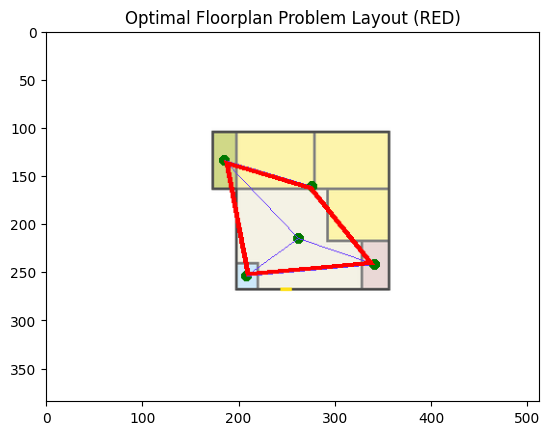

In [13]:
# Print the floor plan layout (Optimal/Solution) 
output_image = Image.fromarray(image_array.copy())
draw = ImageDraw.Draw(output_image)
count = 0
circle_coords = []
for coord, space in binary_variables_combined.items():
    if optimal_solution[coord] == 1:
        draw.ellipse([(coord[0] - 5, coord[1] - 5), (coord[0] + 5, coord[1] + 5)], fill=(0, 120, 0))
        circle_coords.append(coord)
        count += 1
        if count == 5: #I don't need more than 25 (dataset), you can set it to 5 if you process just two images
            break
for pair in constraints['adjacency_relationships']:
    for space1, space2 in pair:
        coord1 = circle_coords[space1]
        coord2 = circle_coords[space2]
        draw.line([(coord1[0], coord1[1]), (coord2[0], coord2[1])], fill=(100, 55, 255), width=1)
convex_hull_coords = []
for coord in circle_coords:
    convex_hull_coords.append((coord[0], coord[1]))

convex_hull = scipy.spatial.ConvexHull(convex_hull_coords)
hull_points = []
for index in convex_hull.vertices:
    hull_points.append((convex_hull_coords[index][0], convex_hull_coords[index][1]))

draw.polygon(hull_points, outline=(255, 0, 0), width=5)

fig, ax = plt.subplots()
ax.imshow(output_image)
ax.axis('on')
ax.set_xlim(0, output_image.width)
ax.set_ylim(output_image.height, 0)
ax.set_aspect('equal')
plt.title('Optimal Floorplan Problem Layout (RED)')
plt.show()